In [12]:
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

In [13]:
load_dotenv()

gen_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
eva_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
opt_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [14]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [15]:
struc_eva_llm = eva_llm.with_structured_output(TweetEvaluation)

In [27]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved","needs_improvement"]
    feedback: str
    iteration: int
    max_iter: int

In [28]:
def gen_tweet(state: TweetState):

    prompt = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    response = gen_llm.invoke(prompt).content
    return {"tweet":response}

In [29]:
def evaluate_tweet(state: TweetState):
    
    prompt = [SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality - Is this fresh, or have you seen it a hundred times before?  
    2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness - Is it short, sharp, and scroll-stopping?  
    4. Virality Potential - Would people retweet or share it?  
    5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"  
    - feedback: One paragraph explaining the strengths and weaknesses 
    """)
    ]

    response = struc_eva_llm.invoke(prompt)
    return {"evaluation":response.evaluation, "feedback": response.feedback}

In [30]:
def optimize_tweet(state: TweetEvaluation):
    prompt = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
        ]

    response = opt_llm.invoke(prompt).content
    iteration = state["iteration"]+1
    return {'tweet': response, 'iteration': iteration}

In [31]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

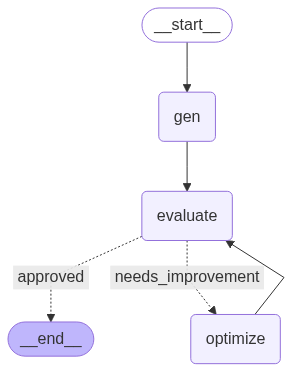

In [32]:
graph = StateGraph(TweetState)

graph.add_node("gen", gen_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimize", optimize_tweet)

graph.add_edge(START,"gen")
graph.add_edge("gen","evaluate")
graph.add_conditional_edges("evaluate",route_evaluation, {"approved": END, "needs_improvement": "optimize"})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow


In [45]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [46]:
result

{'topic': 'srhberhb',
 'tweet': 'Me trying to pronounce the name of any new tech startup these days: srhberhb. Sounds about right. Probably worth billions.',
 'evaluation': 'approved',
 'feedback': "The tweet is concise, humorous, and relatable, capturing the difficulty of pronouncing new tech startup names. The 'srhberhb' approximation is funny and the 'Probably worth billions' adds a layer of irony. It has good virality potential because many people can relate to the experience. The tweet is also well-formatted and under 280 characters.",
 'iteration': 1}